In [1]:
import os
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from pydub import AudioSegment
# ipd.Audio(filename) # load a local WAV file
from pyannote.core import Annotation, Segment
from tqdm import tqdm_notebook


In [2]:

def read_audio_generic(audiofile):
    """
    Function to read audio files with the following extensions
    [".mp3", ".wav", ".au", ".ogg"]
    """
    sampling_rate = -1
    signal = np.array([])
    data = np.array([])
    if audiofile.sample_width == 2:
        data = np.frombuffer(audiofile._data, np.int16)
    elif audiofile.sample_width == 4:
        data = np.frombuffer(audiofile._data, np.int32)

    if data.size > 0:
        sampling_rate = audiofile.frame_rate
        temp_signal = []
        for chn in list(range(audiofile.channels)):
            temp_signal.append(data[chn::audiofile.channels])
        signal = np.array(temp_signal).T
    return sampling_rate, signal


def get_2_speakers(annotation):
    co_occur = annotation*annotation

    most_talking_ind, second_most_talking_ind = np.argsort(np.diag(co_occur))[-2:] # get the diag index of the largest 2 element  

    two_labels = [annotation.labels()[most_talking_ind],annotation.labels()[second_most_talking_ind]]
    return two_labels


def annotation2tuple(annotation, min_len=4):
    segments = []
    for label in annotation.labels():
        for seg in annotation.subset([label]).itersegments():
            if seg.duration > 4:
                segments.append((seg.start, seg.end, label))
    return sorted(segments, key=lambda s: s[0])

def trim_audio(aseg, annotation, min_len=4):
    
    segments = annotation2tuple(annotation, min_len)
    clipped_annotation = Annotation()
    
    clipped = aseg[int(segments[0][0]*1000):int(segments[0][1]*1000)]
    
    last_end, offset = segments[0][1], segments[0][0]
    clipped_annotation[Segment(segments[0][0] - offset, segments[0][1] - offset)]= segments[0][2]

    for start, end, speaker in segments[1:]:
        clipped = clipped.append(aseg[int(start*1000):int(end*1000)])
        
        offset = offset + start - last_end
        last_end = end
        clipped_annotation[Segment(start - offset, end - offset)] = speaker
    return clipped, clipped_annotation


# load data

In [3]:

pyannote_loc = "/Users/zfeng/aws-gitlab/pyannote-audio"
groundtruth_file = pyannote_loc + '/tutorials/data_preparation/AMI/MixHeadset.development.rttm'
audio_folder_location = pyannote_loc + '/data/ami/database/amicorpus/'



In [4]:

from pyannote.database.util import load_rttm
groundtruth = load_rttm(groundtruth_file)


audio_paths = []
for identifier in groundtruth:
    audio_paths.append(
        os.path.join(audio_folder_location, identifier.split('.')[0], 'audio', identifier+'.wav')
    )
audio_paths


['/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2003a/audio/ES2003a.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2003b/audio/ES2003b.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2003c/audio/ES2003c.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2003d/audio/ES2003d.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2011a/audio/ES2011a.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2011b/audio/ES2011b.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2011c/audio/ES2011c.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2011d/audio/ES2011d.Mix-Headset.wav',
 '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/IB4001/audio/IB4001.Mix-Headset.wav',
 '/Users/zfeng/aws-gi

In [6]:
# filename = '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/IS1008a/audio/IS1008a.Mix-Headset.wav'
# annotation = groundtruth['IS1008a.Mix-Headset']
# filename = '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/ES2011b/audio/ES2011b.Mix-Headset.wav'
# annotation = groundtruth['ES2011b.Mix-Headset']
filename = '/Users/zfeng/aws-gitlab/pyannote-audio/data/ami/database/amicorpus/IB4010/audio/IB4010.Mix-Headset.wav'
annotation = groundtruth['IB4010.Mix-Headset']


aseg = AudioSegment.from_file(filename)

print(annotation.labels())

two_labels = get_2_speakers(annotation)
print(two_labels)


['FIE038', 'MIO036', 'MIO046', 'MIO095']
['MIO046', 'MIO036']


In [7]:
rate, sig = read_audio_generic(aseg)


In [8]:
rate, sig.shape


(16000, (47368875, 1))

In [9]:
two_speakers = annotation.subset(two_labels)#.support(.1)
# two_speakers


In [10]:
clipped, clipped_annotation = trim_audio(aseg, two_speakers)


In [11]:
clipped


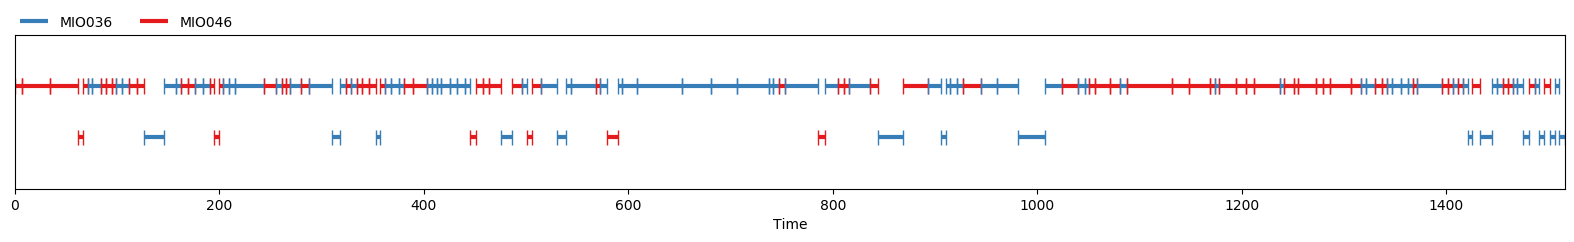

In [12]:
clipped_annotation


# Write clipped audio files

In [5]:
write_path = '../data/ami_2speakers/audios/'
wirte_groundtruth_path = '../data/ami_2speakers/groundtruth.rttm'


In [7]:
for audio_path in tqdm_notebook(audio_paths):
    ami_uri = os.path.split(audio_path)[1][:-4]
    ami_2speakers_uri = ami_uri.split('.')[0] + '.' + '2speakers'

    aseg = AudioSegment.from_file(audio_path)
    
    # filter two most common talking speakers
    
    annotation = groundtruth[ami_uri]
    two_labels = get_2_speakers(annotation)
    two_speakers = annotation.subset(two_labels)

    # clip audio file and ground truth
    clipped, clipped_annotation = trim_audio(aseg, two_speakers)
    clipped_annotation.uri = ami_2speakers_uri
    
    # save files
    clipped.export(os.path.join(write_path, ami_2speakers_uri + '.wav'), format='wav')    
    with open(wirte_groundtruth_path, 'a') as f:
        clipped_annotation.write_rttm(f)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.
